In [1]:
from config import DATASET_PATH, DATASET_URL
from data_handling import DataHandler
from FeatureEngineeringFunction import extract_x_coordinate, extract_y_coordinate
from FeatureEngineeringFunction import timestamp_to_hour, timestamp_to_second

import os
import geohash
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_handler = DataHandler()

In [3]:
data_handler.download_dataset(DATASET_URL, DATASET_PATH)

Checking if path exist
File has been downloaded!


In [4]:
data_handler.extract_file(data_handler.file_name, 
                          data_handler.file_path, 
                          data_handler.folder_path)

Done! Here are the extracted files/ folders
Traffic Management


In [5]:
os.listdir(data_handler.folder_path + "Traffic Management/")

['training.csv']

In [6]:
print(data_handler.folder_path)

./data/traffic_management/


In [7]:
# So now we have full dataset path, we will save to to config.py
FULL_PATH = DATASET_PATH + "Traffic Management/training.csv"

# Feature Engineering

In [8]:
class FeatureEngineering:
    def __init__(self, df):
        self.__class_dataframe = df
    
    def add_new_axis(self):
        self.__class_dataframe =  self.__class_dataframe['geohash6'].apply(extract_x_coordinate)
        self.__class_dataframe =  self.__class_dataframe['geohash6'].apply(extract_y_coordinate)
        return self.__class_dataframe
    
    def add_hour(self):
        self.__class_dataframe =  self.__class_dataframe['timestamp'].apply(timestamp_to_hour)
        return self.__class_dataframe
    
#     def add_second(self, to_index=False):
#         if to_index == False:
#             self.__class_dataframe['second'] = self.__class_dataframe['timestamp'].apply(timestamp_to_second)
#         else:
#             self.__class_dataframe['second'] = self.__class_dataframe['timestamp'].apply(timestamp_to_second)
    
#     def add_previous_count(self):
        

# Exploratory Data Analysis

In [9]:
df = data_handler.load_dataset(FULL_PATH)

In [10]:
df.columns

Index(['geohash6', 'day', 'timestamp', 'demand'], dtype='object')

In [13]:
df[:10]

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468
5,qp03tu,1,12:15,0.023843
6,qp096d,25,3:30,0.007460
7,qp03nr,51,20:45,0.000293
8,qp093r,48,6:15,0.054170
9,qp03r2,4,22:15,0.123463


In [17]:
grouped_by_day = df.groupby("day")

In [24]:
test_group = grouped_by_day.get_group(1)    

In [26]:
group_by_geohash = test_group.groupby("geohash6")

In [27]:
test_group[:5]

,geohash6,day,timestamp,demand,x,y
5,qp03tu,1,12:15,0.023843,-5.336609,90.609741
172,qp03w8,1,21:30,0.090481,-5.358582,90.642700
302,qp098e,1,0:45,0.060016,-5.342102,90.730591
402,qp03x8,1,15:30,0.035535,-5.358582,90.686646
408,qp02zh,1,6:30,0.015310,-5.468445,90.664673


In [18]:
first_group = group_by_geohash.get_group("qp03wu")

NameError: name 'group_by_geohash' is not defined

In [30]:
len(first_group)

72

In [54]:
visualize_of_first = first_group[['timestamp', 'demand']]

In [55]:
def hour_to_num(input_time):
    hour = input_time.split(":")[0]
    minute = input_time.split(":")[1]
    
    return int(hour) * 3600 + int(minute) * 60

In [56]:
visualize_of_first['timestamp_int'] = visualize_of_first['timestamp'].apply(hour_to_num)

/home/thuan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
# visualize_of_first = visualize_of_first.drop("timestamp", axis=1)

In [57]:
visualize_of_first = visualize_of_first.sort_values("timestamp_int")

In [58]:
visualize_of_first = visualize_of_first.drop("timestamp_int", axis=1)
numpy_value = visualize_of_first.values

In [59]:
numpy_value

array([['0:15', 0.0017140675609960373],
       ['0:30', 0.028276379842374525],
       ['0:45', 0.014491950462367472],
       ['1:0', 0.013408333283812251],
       ['1:15', 0.010292974705076405],
       ['1:30', 0.0064738109687738025],
       ['1:45', 0.00678660501555686],
       ['2:0', 0.02169672844434522],
       ['2:15', 0.034506433840945684],
       ['2:30', 0.040936576403051365],
       ['2:45', 0.034955851611778097],
       ['3:0', 0.05195141046039563],
       ['3:15', 0.03552658922389375],
       ['3:30', 0.02912112446904835],
       ['3:45', 0.018893074412463285],
       ['4:0', 0.02873837597486515],
       ['4:15', 0.04653942507711337],
       ['4:30', 0.027363891067171617],
       ['4:45', 0.011340954921222241],
       ['5:0', 0.020501590152042955],
       ['5:15', 0.025485889366451683],
       ['5:30', 0.027776099351035213],
       ['5:45', 0.031193149708225724],
       ['6:0', 0.011771870258614741],
       ['6:15', 0.012953166950441448],
       ['6:30', 0.007487136575530369

In [60]:
x = numpy_value[:,0]
y = numpy_value[:,1]

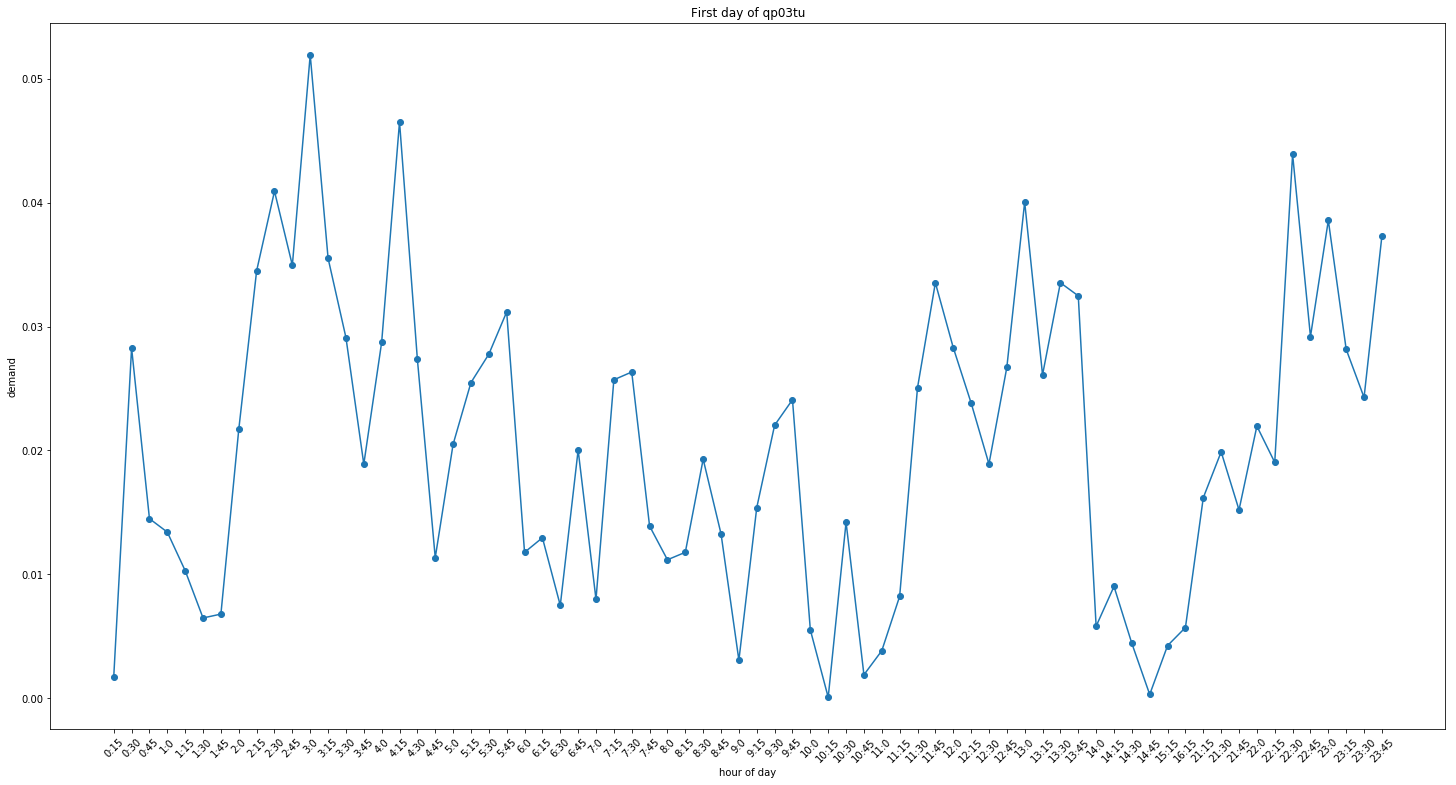

In [66]:
plt.figure(figsize=(25,13))
plt.plot(x, y, "o-")
plt.title("First day of qp03tu")
plt.ylabel("demand")
plt.xlabel("hour of day")
plt.xticks(rotation=45)
plt.show()

In [14]:
class data_visualization:
    def __init__(self, df):
        self.dataframe = df
    
    def hour_to_demand_each_day(self, geohash6_value):
        current_df = self.dataframe
        
        group_by_geohash = current_df.groupby("geohash6") 
        monitoring_geo = group_by_geohash.get_group(geohash6_value) 
        
        timestamp_demand_df = visualize_of_first = first_group[['timestamp', 
                                                                'demand']]
        timestamp_demand_df['timestamp_int'] = timestamp_demand_df['timestamp'].apply(hour_to_num)
        # Because sort by original timestamp is order by dictionary, we
        # create a new feature call timestamp_int (int representation of
        # the original timestamp)
        timestamp_demand_df = timestamp_demand_df.sort_values("timestamp_int") 
        timestamp_demand_df = timestamp_demand_df.drop("timestamp_int", axis=1)
        
        data_to_visualizer = timestamp_demand_df.values
        
        # The plotting
        x = numpy_value[:,0]
        y = numpy_value[:,1]
        
        plt.figure(figsize=(25,13))
        plt.plot(x, y, "o-")
        plt.title("First day of qp03tu")
        plt.ylabel("demand")
        plt.xlabel("hour of day")
        plt.xticks(rotation=45)
        plt.show()

In [15]:
visualization_tool = data_visualization(df)

In [17]:
visualization_tool.hour_to_demand_each_day("qp03wu")

NameError: name 'first_group' is not defined

In [18]:
group_of_day = df.groupby("day")

In [36]:
set(df['geohash6'].values.tolist())

{'qp0dj4',
 'qp08bk',
 'qp03z3',
 'qp02zv',
 'qp096r',
 'qp090z',
 'qp08bg',
 'qp0926',
 'qp0904',
 'qp0949',
 'qp0971',
 'qp09cr',
 'qp09tq',
 'qp0970',
 'qp03md',
 'qp092w',
 'qp09m2',
 'qp09gh',
 'qp08cj',
 'qp09b5',
 'qp0djt',
 'qp09n5',
 'qp09ug',
 'qp09c6',
 'qp0985',
 'qp096m',
 'qp09mt',
 'qp091r',
 'qp09fq',
 'qp03yg',
 'qp03r6',
 'qp0d16',
 'qp09w4',
 'qp0dhw',
 'qp09kj',
 'qp0958',
 'qp09fe',
 'qp08be',
 'qp09e8',
 'qp0928',
 'qp09hz',
 'qp0d5j',
 'qp06pq',
 'qp09dm',
 'qp09j7',
 'qp09s1',
 'qp090c',
 'qp03qz',
 'qp0939',
 'qp09gv',
 'qp0960',
 'qp03rz',
 'qp03xy',
 'qp03wk',
 'qp0djj',
 'qp09fh',
 'qp09gg',
 'qp0d4e',
 'qp02zq',
 'qp0dn4',
 'qp095x',
 'qp03te',
 'qp09ec',
 'qp090s',
 'qp0990',
 'qp03q1',
 'qp09dd',
 'qp0djc',
 'qp09u0',
 'qp094y',
 'qp09cb',
 'qp093s',
 'qp0d5g',
 'qp08fs',
 'qp02zh',
 'qp09jb',
 'qp09gz',
 'qp09fv',
 'qp096v',
 'qp093u',
 'qp09sj',
 'qp03p9',
 'qp0d54',
 'qp09eb',
 'qp09dy',
 'qp098k',
 'qp0d55',
 'qp0998',
 'qp03m3',
 'qp098d',
 'qp097r',

In [44]:
def check_loc_by_day(day_index, hash_code):
    day_group = group_of_day.get_group(day_index)
    sorted_day_group = day_group.sort_values('geohash6')
    check_geohash = sorted_day_group['geohash6'].value_counts()
    if hash_code not in check_geohash.keys():
        return 0
    return check_geohash[hash_code]

In [45]:
list_of_count = []
for i in range(1,62):
    list_of_count.append(check_loc_by_day(i, 'qp0d1s'))

In [47]:
list_of_count

[5,
 3,
 1,
 2,
 3,
 2,
 3,
 10,
 0,
 1,
 3,
 4,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 8,
 0,
 1,
 1,
 0,
 1,
 3,
 0,
 2,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 5,
 2,
 2,
 8,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 5,
 3,
 0,
 2,
 2,
 1,
 6,
 7]

In [48]:
def add_previous_day_count(input_row):
    current_day = input_row['day']
    location = input_row['geohash6']

    if current_day == 1:
        return 0
    else:
        if location not in day_dict[current_day].keys():
            return 0
        else:
            return day_dict[current_day][location]
        
def add_previous_day_count_timestamp(input_row):
    current_day = input_row['day']
    timestamp = input_row['timestamp']

    if current_day == 1:
        return 0
    else:
        if timestamp not in day_dict_timestamp[current_day].keys():
            return 0
        else:
            return day_dict_timestamp[current_day][timestamp]

In [39]:
grouped_by_day = df.groupby("day")

In [40]:
print(day_dict[1]['qp03xh'])

96


In [41]:
holder['qp09bj']

96

In [43]:
df['yesterday_count'] = df.apply(add_previous_day_count, axis=1)

In [49]:
df['yesterday_timestamp_count'] = df.apply(add_previous_day_count_timestamp, axis=1)

In [50]:
df[:10]

,geohash6,day,timestamp,demand,yesterday_count,yesterday_timestamp_count
0,qp03wc,18,20:0,0.020072,85,354
1,qp03pn,10,14:30,0.024721,77,661
2,qp09sw,9,6:15,0.102821,90,851
3,qp0991,32,5:0,0.088755,82,978
4,qp090q,15,4:0,0.074468,73,890
5,qp03tu,1,12:15,0.023843,0,0
6,qp096d,25,3:30,0.007460,49,890
7,qp03nr,51,20:45,0.000293,90,319
8,qp093r,48,6:15,0.054170,76,917
9,qp03r2,4,22:15,0.123463,96,461


In [ ]:
holder_df.columns

In [11]:
GROUPED_BY_DAY = df.groupby('day')

In [17]:
list_of_day = GROUPED_BY_DAY.groups.keys()
day_dict = {}
for day in list_of_day:
    current = GROUPED_BY_DAY.get_group(day)
    holder = dict(current['geohash6'].value_counts())
    day_dict[day] = holder

In [18]:
import pickle

In [22]:
with open("day_density_over_geohash.map", "wb") as f:
    pickle.dump(day_dict, f)

In [46]:
list_of_day = GROUPED_BY_DAY.groups.keys()
day_dict_timestamp = {}
for day in list_of_day:
    current = GROUPED_BY_DAY.get_group(day)
    holder = dict(current['timestamp'].value_counts())
    day_dict_timestamp[day] = holder

In [47]:
with open("day_density_over_timestamp.map", "wb") as f:
    pickle.dump(day_dict_timestamp, f)